In [1]:
from autograd import numpy as np
import matplotlib.pyplot as plt
import glob
from string import ascii_uppercase
import re

from astropy.table import Table, join, Column,vstack, hstack

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as u


shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0


In [84]:
def make_pupil(radius,npix=128,rtot=20*u.m):
    x = np.linspace(-npix/2.,npix/2.,npix)-0.5
    x = x*rtot/npix
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr > radius
    pupil = np.ones_like(rr)
    pupil[mask] = 0
    return pupil.value

In [85]:
pupil = make_pupil(3*u.m)

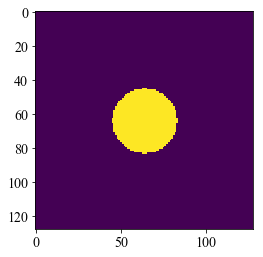

In [86]:
plt.imshow(pupil)

In [87]:
# =========================================================================
# =========================================================================

def mas2rad(x):
    ''' Convenient little function to convert milliarcsec to radians '''
    return x*np.pi/(180*3600*1000)

# =========================================================================
# =========================================================================

def rad2mas(x):
    ''' Convenient little function to convert radians to milliarcseconds '''
    return x/np.pi*(180*3600*1000)


In [88]:
fftshift = np.fft.fftshift
fft = np.fft.fft2

def propagate(pupil,wavelength=1.e-6*u.m):
    scale = pupil
    return fftshift(fft(fftshift(pupil)))

In [89]:
psf = (propagate(pupil))

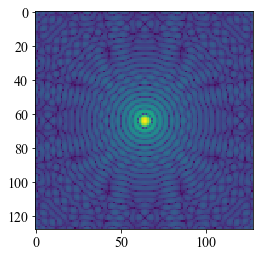

In [90]:
plt.imshow(np.abs(psf)**0.25)
# plt.xlim(500,524)
# plt.ylim(500,524)

In [91]:
uv = fftshift(fft((np.abs(psf))**2))

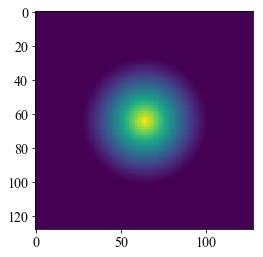

In [92]:
plt.imshow(np.abs(uv))

In [93]:
from autograd import grad, elementwise_grad, jacobian

In [124]:
def get_psf(screen):
    return (propagate(pupil*np.exp(1.j*screen)))
    
def get_uv(psf):
    return fftshift(fft(fftshift(np.abs(psf))**2))

def get_phases(screen):
    return np.angle(get_uv(get_psf(screen)))

In [95]:
from scipy.signal import correlate2d, convolve2d

In [96]:
support = convolve2d(pupil,pupil,mode='same')>0

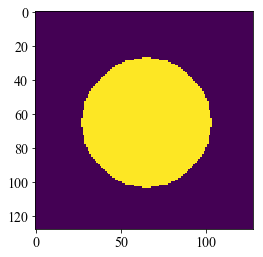

In [97]:
plt.imshow(support)

In [16]:
phasegrad = jacobian(get_phases)

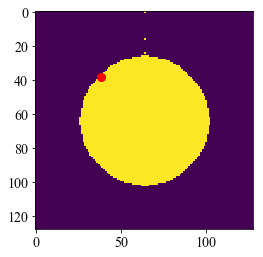

In [98]:
plt.imshow(np.abs(get_phases(pupil))<1e-7)
plt.scatter(38,38,s=64,c='r')

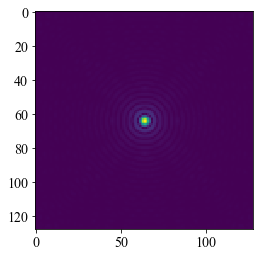

In [18]:
plt.imshow(np.abs(get_uv(pupil)))

In [19]:
%%time 
thisgrad = phasegrad(np.zeros_like(pupil))

CPU times: user 33.6 s, sys: 1.87 s, total: 35.4 s
Wall time: 35.6 s


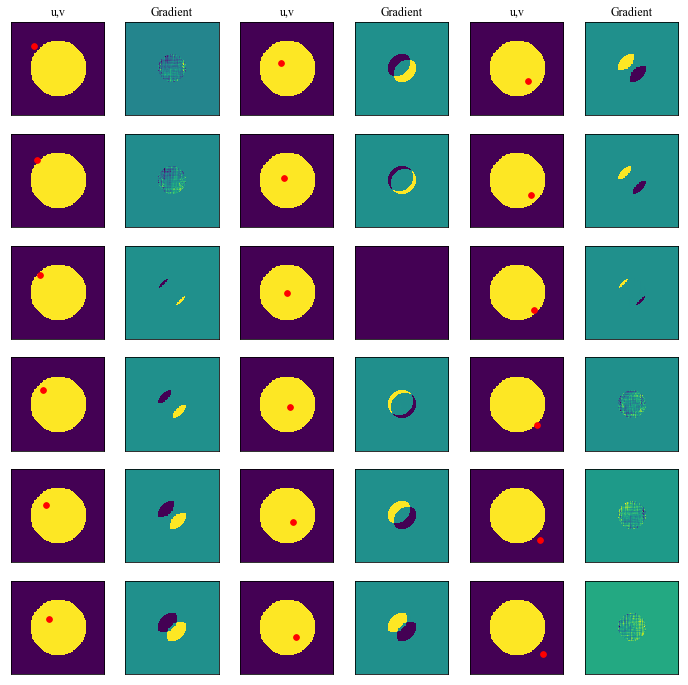

In [20]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        ax[i,1+j].imshow(thisgrad[indices,indices,:,:])
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('u,v')

        ax[i,j].imshow(support)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('jacobian.png',bbox_inches='tight')

In [21]:
help(jacobian)

Help on function jacobian in module autograd.wrap_util:

jacobian(fun, argnum=0, *nary_op_args, **nary_op_kwargs)
    Returns a function which computes the Jacobian of `fun` with respect to
    positional argument number `argnum`, which must be a scalar or array. Unlike
    `grad` it is not restricted to scalar-output functions, but also it cannot
    take derivatives with respect to some argument types (like lists or dicts).
    If the input to `fun` has shape (in1, in2, ...) and the output has shape
    (out1, out2, ...) then the Jacobian has shape (out1, out2, ..., in1, in2, ...).



### Now let's try a coronagraph!

In [107]:
def make_stop(psf):
    x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])-0.5
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr < 8.
    stop = np.ones_like(rr)
    stop[mask] = 0
    return stop



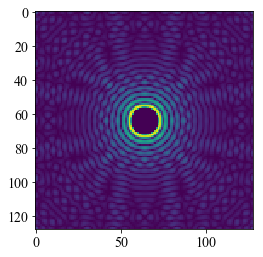

In [115]:
stop = make_stop(psf)
stopped = stop*psf
plt.imshow(np.abs(stopped))

In [109]:
lyot = make_pupil(3*u.m*0.85,npix=128,rtot=20*u.m)

In [110]:
lyot_plane = propagate(stopped)

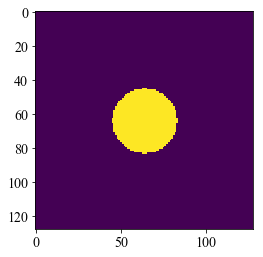

In [111]:
test = (propagate(psf))
plt.imshow(np.abs(test)**0.25)

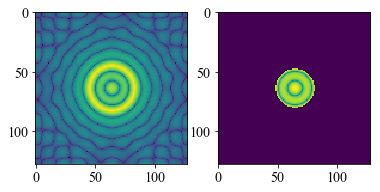

In [112]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(lyot_plane)**0.2)
ax2.imshow(np.abs(lyot_plane*lyot)**0.2)

In [113]:
final = propagate(lyot_plane*lyot)

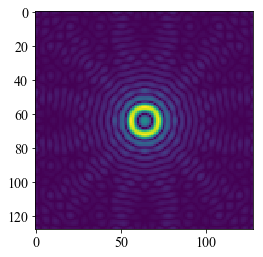

In [114]:
plt.imshow(np.abs(final))

In [135]:
def get_speckles(screen):
    return np.abs(propagate(lyot*propagate(stop*get_psf(screen))))

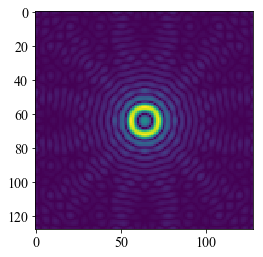

In [136]:
speckles = get_speckles(np.zeros_like(pupil))
plt.imshow(np.abs(speckles))

In [137]:
speckle_grad = jacobian(get_speckles)

In [138]:
%%time 
new_grad = speckle_grad(np.zeros_like(pupil))

CPU times: user 40.6 s, sys: 1.84 s, total: 42.4 s
Wall time: 42.6 s


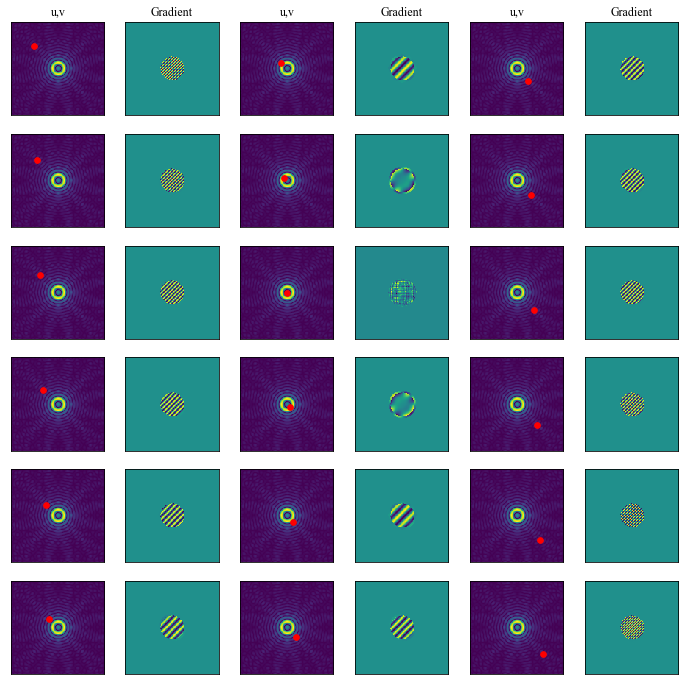

In [140]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        ax[i,1+j].imshow(new_grad[indices,indices,:,:])
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('u,v')

        ax[i,j].imshow(speckles)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('speckle_jacobian.png',bbox_inches='tight')